In [143]:
import matplotlib.pyplot as plt
def cv2_imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.stats import mode

import pickle
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
from tqdm import tqdm

from mediapipe.python.solutions.drawing_utils import DrawingSpec
from mediapipe.python.solutions.hands import HandLandmark
from mediapipe.python.solutions.pose import PoseLandmark

In [2]:
class FullBodyPoseEmbedder(object):
  """Converts 3D pose landmarks into 3D embedding."""

  def __init__(self, torso_size_multiplier=2.5):
    # Multiplier to apply to the torso to get minimal body size.
    self._torso_size_multiplier = torso_size_multiplier

    # Names of the landmarks as they appear in the prediction.
    self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

  def __call__(self, landmarks):
    """Normalizes pose landmarks and converts to embedding
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances defined in `_get_pose_distance_embedding`.
    """
    assert landmarks.shape[0] == len(self._landmark_names), 'Unexpected number of landmarks: {}'.format(landmarks.shape[0])

    # Get pose landmarks.
    landmarks = np.copy(landmarks)

    # Normalize landmarks.
    landmarks = self._normalize_pose_landmarks(landmarks)

    # Get embedding.
    embedding = self._get_pose_distance_embedding(landmarks)

    return embedding

  def _normalize_pose_landmarks(self, landmarks):
    """Normalizes landmarks translation and scale."""
    landmarks = np.copy(landmarks)

    # Normalize translation.
    pose_center = self._get_pose_center(landmarks)
    landmarks -= pose_center

    # Normalize scale.
    pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier)
    landmarks /= pose_size
    # Multiplication by 100 is not required, but makes it eaasier to debug.
    landmarks *= 100

    return landmarks

  def _get_pose_center(self, landmarks):
    """Calculates pose center as point between hips."""
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    center = (left_hip + right_hip) * 0.5
    return center

  def _get_pose_size(self, landmarks, torso_size_multiplier):
    """Calculates pose size.
    
    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # This approach uses only 2D landmarks to compute pose size.
    landmarks = landmarks[:, :2]

    # Hips center.
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    hips = (left_hip + right_hip) * 0.5

    # Shoulders center.
    left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
    right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]
    shoulders = (left_shoulder + right_shoulder) * 0.5

    # Torso size as the minimum body size.
    torso_size = np.linalg.norm(shoulders - hips)

    # Max dist to pose center.
    pose_center = self._get_pose_center(landmarks)
    max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

    return max(torso_size * torso_size_multiplier, max_dist)

  def _get_pose_distance_embedding(self, landmarks):
    """Converts pose landmarks into 3D embedding.

    We use several pairwise 3D distances to form pose embedding. All distances
    include X and Y components with sign. We differnt types of pairs to cover
    different pose classes. Feel free to remove some or add new.
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances.
    """
    embedding = np.array([
        # One joint.

        self._get_distance(
            self._get_average_by_names(landmarks, 'left_hip', 'right_hip'),
            self._get_average_by_names(landmarks, 'left_shoulder', 'right_shoulder')),

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_elbow'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_elbow'),

        self._get_distance_by_names(landmarks, 'left_elbow', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_elbow', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_knee'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_knee', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_knee', 'right_ankle'),

        # Two joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_ankle'),

        # Four joints.

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Five joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_ankle'),
        
        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Cross body.

        self._get_distance_by_names(landmarks, 'left_elbow', 'right_elbow'),
        self._get_distance_by_names(landmarks, 'left_knee', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_wrist', 'right_wrist'),
        self._get_distance_by_names(landmarks, 'left_ankle', 'right_ankle'),

        # Body bent direction.

        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'left_wrist', 'left_ankle'),
        #     landmarks[self._landmark_names.index('left_hip')]),
        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'right_wrist', 'right_ankle'),
        #     landmarks[self._landmark_names.index('right_hip')]),
    ])

    return embedding

  def _get_average_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return (lmk_from + lmk_to) * 0.5

  def _get_distance_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return self._get_distance(lmk_from, lmk_to)

  def _get_distance(self, lmk_from, lmk_to):
    return lmk_to - lmk_from

In [25]:
with open("video_heavy_pose.pickle", "rb") as file:
    poses = pickle.load(file)

poses_np = []
for p in poses:
    if p:
        x = np.zeros((33,3))
        for i in range(33):
            x[i] = [p[0][i].x * 640, p[0][i].y * 480, p[0][i].z * 640]
        poses_np.append(x)
    else:
        poses_np.append(None)

In [8]:
embedder = FullBodyPoseEmbedder()

In [82]:
embeddings = [embedder(p).ravel() for p in poses_np if p is not None]
frames = [i for i,p in enumerate(poses_np) if p is not None]
X = np.vstack(embeddings)

annotations = pd.read_csv('annotations.csv', index_col=None)
labels = annotations['class'].iloc[frames].astype('category').cat.codes.to_numpy()
label_names = annotations['class'].astype('category').cat.categories.tolist()
annotations = annotations.iloc[frames]

In [83]:
annotations.head()

,frame,filename,clip_id,class
17,17,000017_color.png,0,0
18,18,000018_color.png,0,0
19,19,000019_color.png,1,0
20,20,000020_color.png,1,0
21,21,000021_color.png,1,0


In [63]:

tsne = TSNE(n_components=3, 
            random_state=42,
            init='pca', 
            learning_rate='auto')

X_3d = tsne.fit_transform(X)


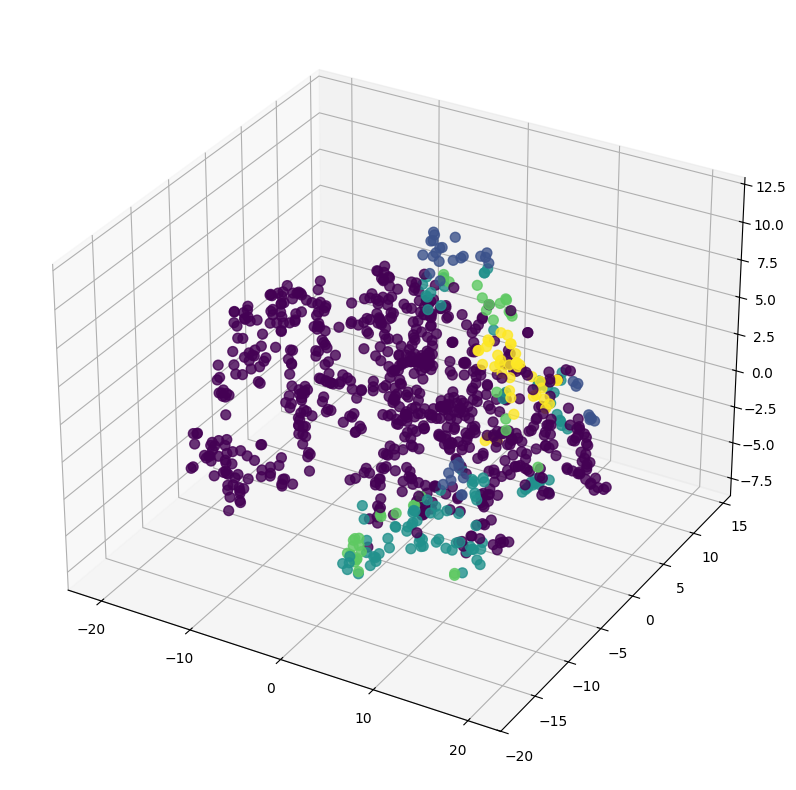

In [64]:
# # 3. Visualization
# plt.figure(figsize=(8, 6))

# # Scatter plot of the 2D t-SNE components, colored by cluster
# scatter = plt.scatter3d(X_2d[:, 0], X_2d[:, 1], 
#                       c=labels, 
#                       cmap='viridis',
#                       s=100, 
#                       alpha=0.8)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the three t-SNE components
scatter = ax.scatter(
    X_3d[:, 0], # X-axis
    X_3d[:, 1], # Y-axis
    X_3d[:, 2], # Z-axis
    c=labels,          # Color based on cluster labels
    cmap='viridis',    # Color map
    s=50,              # Marker size
    alpha=0.8
)

In [80]:
# --- 3. Prepare Data for Plotly ---
# Create a DataFrame for easy plotting with labels
# label_names = ['Base', 'A', 'B', 'C', 'D']
tsne_df = pd.DataFrame(X_3d, columns=['C1', 'C2', 'C3'])
tsne_df['Cluster'] = [label_names[l] for l in labels]
tsne_df['Frame_Index'] = tsne_df.index # Add index for hover text

fig = px.scatter_3d(
    tsne_df, 
    x='C1', 
    y='C2', 
    z='C3', 
    color='Cluster',  # Color points by the cluster label
    symbol='Cluster', # Use different shapes for clusters
    hover_data=['Frame_Index'], # Show frame index when hovering
    title='Interactive 3D t-SNE Visualization of 99D Pose Embeddings',
    labels={'C1': 't-SNE Component 1', 
            'C2': 't-SNE Component 2', 
            'C3': 't-SNE Component 3'}
)

# Customize the display layout
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    legend_title="Pose Cluster"
)

# Display the interactive plot (usually in a notebook environment)
fig.show(renderer='iframe')



In [159]:

# Initialize the model and the cross-validator
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced')
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, probability=False)
xgb_model = XGBClassifier(
    objective='multi:softmax', 
    use_label_encoder=False, 
    eval_metric='mlogloss',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
knn_model = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

models = {
    "Logistic Regression": lr_model,
    "SVM (RBF)": svm_model,
    # "XGBoost": xgb_model
    "kNN": knn_model
}


logo = LeaveOneGroupOut()
# Lists to store results
# Dictionary to store all predictions for final metrics
results = {name: {'true': [], 'pred': [], 'fold_acc': [], 'fold_vote': [], 'fold_true': []} for name in models.keys()}

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# --- 2. LOOCV Loop ---
# LOOCV creates N splits, where N is the number of samples in X.
for train_index, test_index in logo.split(X, labels, annotations['clip_id'].to_numpy()):
    
    # Slice the data for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Fit Scaler ONLY on the training data and transform both sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        
        # SVM and LR use the scaled data, XGBoost is tree-based and does not require scaling
        X_train_fit = X_train_scaled if name != "XGBoost" else X_train
        X_test_fit = X_test_scaled if name != "XGBoost" else X_test

        # Train and Predict
        model.fit(X_train_fit, y_train)
        y_pred = model.predict(X_test_fit)
        
        # Store results
        results[name]['true'].extend(y_test)
        results[name]['pred'].extend(y_pred)

        results[name]['fold_acc'].extend([accuracy_score(y_test, y_pred)])
        results[name]['fold_vote'].extend([mode(y_pred).mode])
        results[name]['fold_true'].extend([mode(y_test).mode])

final_metrics = []

for name, res in results.items():
    true = np.array(res['true'])
    pred = np.array(res['pred'])
    
    # Calculate metrics
    accuracy = accuracy_score(true, pred)
    b_accuracy = balanced_accuracy_score(true, pred)
    f1_macro = f1_score(true, pred, average='macro')
    
    final_metrics.append({
        "Model": name,
        "Accuracy": f"{accuracy:.4f}",
        "Balanced Accuracy": f"{b_accuracy:.4f}",
        "Macro F1-Score": f"{f1_macro:.4f}"
    })

# Display the comparison table
comparison_df = pd.DataFrame(final_metrics)
print(comparison_df)
    # # Train the model on N-1 samples
    # model.fit(X_train, y_train)
    
    # # Predict on the 1 held-out sample
    # y_pred = model.predict(X_test)
    
    # # Store results
    # predictions.append(y_pred)
    # true_labels.append(y_test)
    
    # # Optional: Calculate accuracy for this single fold (1 or 0)
    # fold_accuracies.append(accuracy_score(y_test, y_pred))

# --- 3. Final Evaluation ---
# Calculate the overall accuracy across all folds
# true_labels = np.concatenate(true_labels)
# predictions = np.concatenate(predictions)
# overall_accuracy = accuracy_score(true_labels, predictions)
# b_accuracy = balanced_accuracy_score(true_labels, predictions)
# f1_macro = f1_score(true_labels, predictions, average='macro')

# # Option B: Weighted F1-Score (Recommended for imbalanced datasets)
# # Calculates F1 for each class and weights the mean by the number of true instances for each class.
# f1_weighted = f1_score(true_labels, predictions, average='weighted')

# print(f"Total samples (N): {len(X)}")
# print(f"Total folds performed: {len(fold_accuracies)}")
# print(f"Overall LOOCV Accuracy: {overall_accuracy:.4f}")
# print(f"True Labels: {np.array(true_labels)}")
# print(f"Predictions: {np.array(predictions)}")
# print(f"Balanced Accuracy: {b_accuracy:.4f}")
# print(f"Macro F1-Score:    {f1_macro:.4f} (Unweighted mean F1 per class)")
# print(f"Weighted F1-Score: {f1_weighted:.4f} (Weighted by class support)")

17    0
18    0
Name: clip_id, dtype: int64
17    0
18    0
Name: clip_id, dtype: int64
17    0
18    0
Name: clip_id, dtype: int64
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    1
59    1
60    1
61    1
62    1
63    1
64    1
65    1
66    1
67    1
68    1
69    1
70    1
71    1
72    1
73    1
74    1
75    1
Name: clip_id, dtype: int64
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    1
59    1
60    1
61    1
62    1
63    1
64    1
65    1
66    1


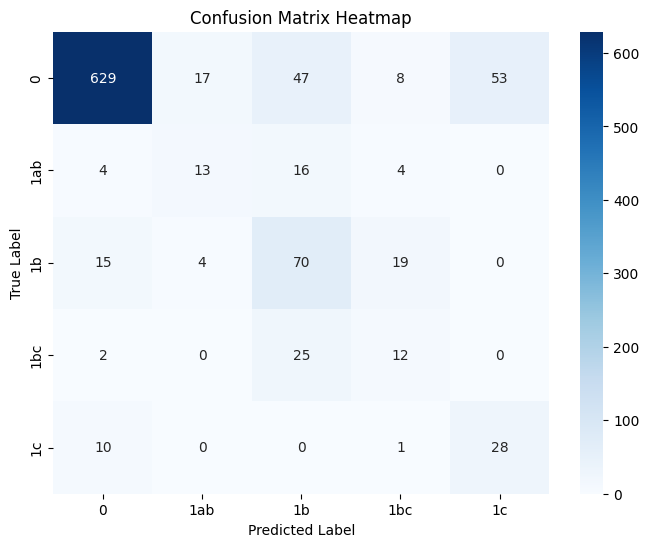

In [125]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(results['Logistic Regression']['true'], results['Logistic Regression']['pred'])

plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(
    cm, 
    annot=True,              # Annotate cells with the numeric value
    fmt='d',                 # Format as integers (decimal)
    cmap='Blues',            # Color map (e.g., 'Blues', 'viridis', 'YlGnBu')
    xticklabels=label_names, # Labels for predicted classes (X-axis)
    yticklabels=label_names  # Labels for true classes (Y-axis)
)

# Set labels and title
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [111]:
clip_labels = []
for i in annotations['clip_id'].unique():
    clip_labels.append(annotations[annotations['clip_id'] == i]['class'].iloc[0])

In [132]:
fold_accuracies = np.array(results['Logistic Regression']['fold_acc'])


0.7241379310344828

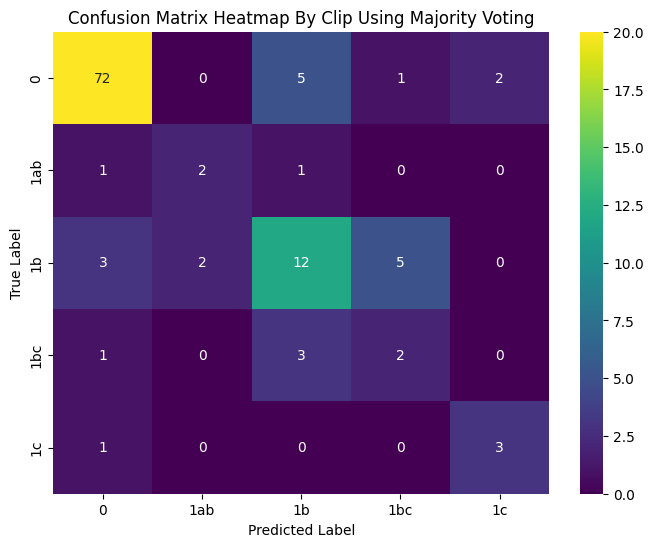

0.6057575757575757
0.7844827586206896


In [163]:
ft = results['Logistic Regression']['fold_true']
fv = results['Logistic Regression']['fold_vote']
cm = confusion_matrix(ft, fv)

plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(
    cm, 
    annot=True,              # Annotate cells with the numeric value
    fmt='d',                 # Format as integers (decimal)
    cmap='viridis',            # Color map (e.g., 'Blues', 'viridis', 'YlGnBu')
    xticklabels=label_names, # Labels for predicted classes (X-axis)
    yticklabels=label_names,  # Labels for true classes (Y-axis)
    vmax=20
)

# Set labels and title
plt.title('Confusion Matrix Heatmap By Clip Using Majority Voting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('clip_cm.png')
plt.show()

print(balanced_accuracy_score(ft, fv))
print(accuracy_score(ft, fv))

pd.DataFrame({'clip_true': ft, 'clip_pred': fv}).to_csv('clip_preds.csv')